# Homework #2

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import json
import re

import numpy as np
import pandas as pd

# Problem 2: Word vectors via Pointwise Mutual Information (PMI)

### In this problem we will investigate another way of creating word representation from word co-occurrences. For this we will create a word-word matrix that counts the number of times that two words appear close to each other.

## More formally:

### The pointwise mutual information (PMI) for a (word, context) pair in a corpus is defined as the probability of their co-occurrence divided by the probabilities of them appearing individually, 
## $$
{\rm pmi}(w, c) = \log \frac{p(w, c)}{p(w) p(c)}
$$

## $$
p(w, c) = \frac{
f_{i,j}
}{
\sum_{i=1}^N \sum_{j=1}^N f_{i,j}
}, \quad 
p(w) = \frac{
\sum_{j=1}^N f_{i,j}
}{
\sum_{i=1}^N \sum_{j=1}^N f_{i,j}
}, \quad
p(c) = \frac{
\sum_{i=1}^N f_{i,j}
}{
\sum_{i=1}^N \sum_{j=1}^N f_{i,j}
}
$$
### where $f_{i,j}$ is the word-word count matrix. <br />
### In addition we can define the positive pointwise mutual information as, 
## $$
{\rm ppmi}(w, c) = {\rm max}\left[{\rm pmi(w,c)}, 0 \right]
$$

## We will implement this on our wiki featured articles dataset

In [3]:
wiki_feat_df = pd.read_csv('kdwd_featured_articles.csv')
wiki_feat_df.sample(5)

,page_id,page_title,page_views,intro_text
3511,7015404,Isopogon anethifolius,219,"'Isopogon anethifolius', commonly known as nar..."
1343,321495,Bill O'Reilly (cricketer),683,William Joseph O'Reilly (20 December 19056 Oct...
1376,335537,1999 FIFA Women's World Cup,1994,The 1999 FIFA Women's World Cup was the third ...
1404,346987,Referendum Party,4794,"The Referendum Party was a Eurosceptic, single..."
4079,14099454,The Chaser APEC pranks,555,The Chaser APEC pranks were a series of comic ...


In [4]:
corpus = wiki_feat_df['intro_text'].tolist()

In [5]:
def get_tokens(text):
    token_pattern = r"\b\w\w+\\?'?s?(?:-\w+)?\b"
    return re.findall(token_pattern, text.lower())

In [6]:
from collections import Counter

In [7]:
unigram_counts = Counter()
for doc in corpus:
    # your code here
    tokens = get_tokens(doc)
    for word in tokens:
        unigram_counts[word] += 1
vocab = {token: n for n, token in enumerate(pd.Series(unigram_counts).sort_values().index)}
inv_vocab = {v: k for k, v in vocab.items()}
print('vocabulary size: {}'.format(len(unigram_counts)))

vocabulary size: 72750


### Skip-grams are a generalization of n-grams: https://en.wikipedia.org/wiki/N-gram#Skip-gram
### We will use this term here to find pairs of word within a context window, meaning that all words separated by max N words will be considered a bigram

In [8]:
# use skip-2-grams and context length 2 in each direction
word_window_len = 2
skipgram_counts = Counter()
for doc in corpus:
    tokens = get_tokens(doc)
    for token_idx, token in enumerate(tokens):
        for context_token in tokens[token_idx - word_window_len:token_idx + word_window_len]:
            if token != context_token:
                skipgram_counts[(vocab[token], vocab[context_token])] += 1
print('number of skipgrams:', len(skipgram_counts))
print('most common:')

[((inv_vocab[t1], inv_vocab[t2]), v) for (t1, t2), v in skipgram_counts.most_common(5)]

number of skipgrams: 1981470
most common:


[(('of', 'the'), 42125),
 (('the', 'of'), 23088),
 (('in', 'the'), 18020),
 (('the', 'in'), 17652),
 (('and', 'the'), 11390)]

### Now let's create a sparse matrix that contains word-word co-occurrence counts

In [9]:
from scipy import sparse as ssp

row_indxs = []
col_indxs = []
dat_values = []


# your code here
row_indxs = [t1 for (t1, t2), v in skipgram_counts.items()]
col_indxs = [t2 for (t1, t2), v in skipgram_counts.items()]
dat_values = [v for (t1, t2), v in skipgram_counts.items()]

In [10]:
wwcnt_mat = ssp.csr_matrix((dat_values, (row_indxs, col_indxs)))
wwcnt_mat

<72750x72750 sparse matrix of type '<class 'numpy.int32'>'
	with 1981470 stored elements in Compressed Sparse Row format>

### Next, create the PPMI matrix

In [11]:
# reusable quantities
num_skipgrams = wwcnt_mat.sum()
sum_over_words = np.array(wwcnt_mat.sum(axis=0)).flatten()
sum_over_contexts = np.array(wwcnt_mat.sum(axis=1)).flatten()

ppmi_dat_values = []   # positive pointwise mutial information
row_indxs = []  # for creating sparce matrices
col_indxs = []  # for creating sparce matrices
for (tok_word, tok_context), sg_count in skipgram_counts.items():

    nwc = sg_count
    Pwc = nwc / num_skipgrams
    nw = sum_over_words[tok_word]
    Pw = nw / num_skipgrams
    nc = sum_over_words[tok_context]
    Pc = nc / num_skipgrams
    
    pmi = np.log2(Pwc / (Pw * Pc))   
    ppmi = max(pmi, 0)
    
    row_indxs.append(tok_word)
    col_indxs.append(tok_context)
    ppmi_dat_values.append(ppmi)

ppmi_mat = ssp.csr_matrix((ppmi_dat_values, (row_indxs, col_indxs)))
ppmi_mat

<72750x72750 sparse matrix of type '<class 'numpy.float64'>'
	with 1981470 stored elements in Compressed Sparse Row format>

## Use `ppmi_mat` to investigate the most similar values to a few test terms.

In [12]:
# to speed up calculation we do dimentionality reduction here
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD


In [13]:
svd = TruncatedSVD(n_components=64, random_state=6006)
trafo_ppmi_mat = svd.fit_transform(ppmi_mat)
sim_mat = cosine_similarity(trafo_ppmi_mat)

MemoryError: 

In [ ]:
token = 'eminem'
# print most similar terms
word_idx = vocab[token]
for idx, row in pd.Series(sim_mat[word_idx]).sort_values(ascending=False).head(10).iteritems():
    print('%.3f' % row, inv_vocab[idx])

In [ ]:
token = 'quantum'
# print most similar terms
word_idx = vocab[token]
for idx, row in pd.Series(sim_mat[word_idx]).sort_values(ascending=False).head(10).iteritems():
    print('%.3f' % row, inv_vocab[idx])

## In what way do these embeddings differ the TfIdf based ones we covered in class? Can you think of advantages/disadvantages for each approach?

In [14]:
# Your answer here!
print('The difference between these embeddings and TfIdf is that these embeddings find similar terms by cosine similarity, while TfIdf based ones do that by word counting. The advantage of cosine similarity is that it can find out the relationship among different words, which is the disadvantage of TfIdf based ones since they focus on word counting. The disadvantage of these embeddings is that it requires huge amount and types of data/words to calculate the relationship, while TfIdf based ones do not need.')

The difference between these embeddings and TfIdf is that these embeddings find similar terms by cosine similarity, while TfIdf based ones do that by word counting. The advantage of cosine similarity is that it can find out the relationship among different words, which is the disadvantage of TfIdf based ones since they focus on word counting. The disadvantage of these embeddings is that it requires huge amount and types of data/words to calculate the relationship, while TfIdf based ones do not need.


# Problem 4: Corporate Similarity and Returns
### In this example we'll explore how to use NLP to measure corporate similarity

### In particular we will
 - ### Make word vectors for firms in order to get an NLP measure of similarity
 - ### Measure the quality of this similarity metric by predicting future co-movement of returns. 
 
## Step X: This problem uses a few concepts of basic modeling such as `sklearn.model_selection.train_test_split` and `sklearn.linear_model.LinearRegression`
## Feel free to read some of the sklearn documentation, but otherwise we will cover these concepts next class
 

# $ \\ $
## Step 0: Load the MD&A section from Form-10-K from 2016

In [66]:
with open('parsed_mda.json') as f:
    data = json.load(f)

### Next, take only the first filing for each company

In [67]:
clean = []
seen = set()
for item in data:
    if item['ticker'] in seen:
        continue
    else:
        seen.add(item['ticker'])
        clean.append(item)
data = clean
del clean

### Now load the price data for 2015-2018

In [68]:
prices = pd.read_csv(
    'sp500_prices.csv', 
    index_col=0, 
    parse_dates=True
).loc['2015-01-01':'2018-01-01']

In [69]:
prices.head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,152.857296,41.911850,59.166809,37.31,83.567918,19.647773,72.340,2.69,157.835250,12.207402,...,NaN,137.601094,32.876454,51.006224,40.568729,36.487373,48.740797,110.052964,27.623683,42.403000
2015-01-05,149.409947,41.921185,58.053335,37.07,82.156933,19.374481,71.980,2.66,155.754803,11.859892,...,NaN,135.259187,32.503272,49.893361,39.819696,34.216494,47.750487,114.158329,26.588649,42.148444
2015-01-06,147.816713,41.445126,57.765986,36.13,81.564320,19.013344,70.530,2.63,155.645306,11.592576,...,NaN,132.373957,32.676210,49.225643,39.247454,34.015277,47.164385,113.190639,25.573145,41.737240
2015-01-07,148.888186,41.781167,60.100691,37.28,83.276314,18.598525,71.110,2.58,158.989948,11.610397,...,NaN,136.261523,32.958372,49.856265,39.261411,34.283567,48.727324,116.005740,25.812374,42.598811
2015-01-08,152.456658,42.639940,60.729266,38.96,84.546201,18.788854,72.915,2.61,160.383549,11.788608,...,NaN,137.900858,33.340656,51.228796,40.136058,34.542275,49.576161,117.237350,26.178542,43.254780


In [70]:
data_tickers = [item['ticker'] for item in data]
assert len(data_tickers) == len(set(data_tickers)), 'non-unique tickers, this will not work'

## Step 1: clean the text
### Much of NLP boils down to doing reasonable processing on text.
### First, we'll try out very minimial processing

In [71]:
def clean_mda_simple(mda):
    return mda.lower()

In [72]:
# add import here
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [73]:
vectorizer = CountVectorizer()
word_lower = []
for item in data:
    word_lower.append(clean_mda_simple(item['mda']))
word_vecs = vectorizer.fit_transform(word_lower)
vocab = {token: n for n, token in enumerate(pd.Series(vectorizer.vocabulary_).sort_values().index)}
inv_vocab = {v: k for k, v in vocab.items()}

## Step 2: Pairwise Word similarity
### Calculate the pariwise cosine similarity between word vectors
### Make the cosine similarities into a dataframe indexed/columned on ticker symbols

In [74]:
word_sims = cosine_similarity(word_vecs)

In [75]:
df = pd.DataFrame(word_sims, index = data_tickers, columns = data_tickers)

In [76]:
df.head()

,ADBE,AAP,AMD,AES,AMG,AFL,AIV,AKAM,SO,ALK,...,JCI,MU,RJF,ROK,SWKS,SBUX,SNPS,TSN,TDG,VIAB
ADBE,1.000000,0.919373,0.918374,0.867142,0.867563,0.880981,0.877659,0.938738,0.0,0.893183,...,0.832302,0.905662,0.875531,0.887068,0.936977,0.873493,0.950022,0.920298,0.852041,0.884839
AAP,0.919373,1.000000,0.946086,0.905947,0.895632,0.916336,0.912843,0.943285,0.0,0.911751,...,0.871063,0.943673,0.913981,0.923592,0.921975,0.904917,0.926982,0.942927,0.898032,0.922768
AMD,0.918374,0.946086,1.000000,0.922994,0.908136,0.907567,0.906314,0.929189,0.0,0.927133,...,0.882126,0.932985,0.904359,0.898625,0.926256,0.885955,0.924474,0.943245,0.887473,0.916984
AES,0.867142,0.905947,0.922994,1.000000,0.876463,0.908254,0.901906,0.908670,0.0,0.908768,...,0.915712,0.908622,0.913063,0.878228,0.888201,0.870428,0.888656,0.910719,0.895787,0.898210
AMG,0.867563,0.895632,0.908136,0.876463,1.000000,0.871050,0.869783,0.893722,0.0,0.898257,...,0.808114,0.872916,0.898773,0.865362,0.867588,0.840331,0.882624,0.896644,0.814938,0.864113


## Step 2a: Why `cosine_similarity` and not another measure?

In [77]:
# ANSWER GOES HERE
print("cosine_similarity produces results with absolute value equal or smaller than 1, which are easy to understand and compare.")

cosine_similarity produces results with absolute value equal or smaller than 1, which are easy to understand and compare.


## Step 3: Wrangle the price and word data
### Our goal here is to have a dataframe which is indexed on PAIRS of tickers and has columns
 - ### `returns_correlation`: the correlation of returns for those two tickers from Jan 1 2016 to Jan 1 2017
 - ### `word_similarity`: the cosine similarity of the word vectors for the two companies' MD&A sections
 
## Tips
 - ### NB: use pct_change to calculate returns in pandas
 - ### NB: use the pandas builtin corr function to calculate correlations (we don't need anything fancy)
 - ### NB: the index of the dataframe should have two columns (the tickers)

In [78]:
# one way you might do this is
rets = prices.pct_change()
rets = rets.loc['2016-01-01':'2017-01-01']
rets_cor = rets.corr().stack().to_frame(name = 'returns_correlation') # calculate returns correlations
word_cor = df.stack()#  calcuate the word similarities in the right shape
word_cor.name = 'word_similarity'
all_data = rets_cor.join(word_cor)
all_data = all_data.dropna()
all_data.head()

returns_correlation  word_similarity
ACN ACN              1.000000         1.000000
    ADBE             0.555422         0.916491
    AMD              0.215997         0.889912
    AAP              0.231908         0.901718
    AES              0.351658         0.871632

## Step 3a: 
 - ### What is the contemperaneous correlation of these data?
 - ### Make a scatter plot of the returns correlation and word similarities

In [79]:
all_data.corr()

,returns_correlation,word_similarity
returns_correlation,1.00000,0.05523
word_similarity,0.05523,1.00000


In [80]:
## This should be about 12%. That's not bad, but we can do better
# ? what should be 12%? 

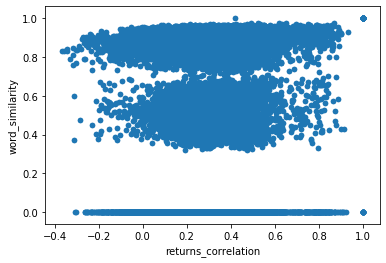

In [81]:
all_data.plot.scatter(x='returns_correlation', y='word_similarity')

## Part 4: Try to predict the future returns correlations
### Use OLS (`LinearRegression`) to predict `returns_correlation` from `word_similarity`. 
### What is the (contemperaneous) out of sample performance?

In [82]:
data_df = np.array(all_data)
feature_cols = data_df[:,1:]
target_col = data_df[:,0]

In [83]:
data_df

array([[1.        , 1.        ],
       [0.55542154, 0.91649091],
       [0.21599703, 0.88991216],
       ...,
       [0.34410792, 0.89216151],
       [0.32758096, 0.91544081],
       [1.        , 1.        ]])

In [84]:
feature_cols

array([[1.        ],
       [0.91649091],
       [0.88991216],
       ...,
       [0.89216151],
       [0.91544081],
       [1.        ]])

In [85]:
target_col

array([1.        , 0.55542154, 0.21599703, ..., 0.34410792, 0.32758096,
       1.        ])

In [86]:
# add code here
from sklearn import linear_model
from sklearn.model_selection import train_test_split

reg = linear_model.LinearRegression()# add code here
X_train, X_test, y_train, y_test = train_test_split(feature_cols,target_col,test_size=0.4, random_state=0)

reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.0034679984901585525

In [87]:
reg.coef_

array([0.02708369])

In [89]:
#? pd.Series(reg.coef_, index=feature_cols)

### This is not amazing. We can do better!

## $ \\ $ 

## Part 5: Repeat, but be careful
### Here we will see if we can clean the data better

### Things to try
 - ### Look at the histograms of word similarities to see if we can "ignore" some ill-behaved data
 - ### Try limiting how greedy the `TFIDFVectorizer` is: `min_df`, `max_df`, `max_features`, etc.
 
### We will examine our data and look for things that look out of place
 - ### We will ultimately want our data to look normally distributed


In [90]:
def clean_mda(mda):
    paras = [p.lower() for p in mda.split('\n') if len(p) > 40]
    cleaned =  ' '.join(paras)
    words = cleaned.split()
    words = [word for word in words if len(word) > 2]
    if len(words) > 10:
        return ' '.join(words)
    else:
        return ''

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(
    min_df = 3,
    max_df = 1.0,
    max_features= None
)
word_vecs = vec.fit_transform((clean_mda(item['mda']) for item in data))

vocab = {token: n for n, token in enumerate(pd.Series(vec.vocabulary_).sort_values().index)}
inv_vocab = {v: k for k, v in vocab.items()}

word_sims =  cosine_similarity(word_vecs)
# Lots of word similarities are all zeros- so we'll ignore
# add code here to remove rows of word_sims where all the elements are zero


In [92]:
type(data_tickers)

list

In [93]:
data_tickers = np.array(data_tickers)

In [94]:
type(data_tickers)

numpy.ndarray

In [95]:
data_tickers_wo_zero = data_tickers[word_sims.sum(axis = 1) != 0]
word_sims_wo_zero = word_sims[word_sims.sum(axis = 1) != 0]
df_wo_zero = pd.DataFrame(word_sims_wo_zero, index = data_tickers_wo_zero, columns = data_tickers)

In [96]:
df_wo_zero.head()

,ADBE,AAP,AMD,AES,AMG,AFL,AIV,AKAM,SO,ALK,...,JCI,MU,RJF,ROK,SWKS,SBUX,SNPS,TSN,TDG,VIAB
ADBE,1.000000,0.778558,0.774899,0.733078,0.716311,0.729026,0.531221,0.846542,0.0,0.709761,...,0.707491,0.761365,0.770023,0.775591,0.838928,0.691573,0.854355,0.781628,0.751405,0.746832
AAP,0.778558,1.000000,0.813690,0.789807,0.754933,0.784507,0.568569,0.858525,0.0,0.760760,...,0.753291,0.803720,0.808612,0.835261,0.795753,0.793316,0.803614,0.796018,0.803191,0.784600
AMD,0.774899,0.813690,1.000000,0.808407,0.778368,0.773822,0.555433,0.836496,0.0,0.738259,...,0.808158,0.820952,0.805966,0.782649,0.821668,0.712950,0.822254,0.818619,0.811516,0.779165
AES,0.733078,0.789807,0.808407,1.000000,0.728791,0.811388,0.560585,0.834174,0.0,0.750890,...,0.847035,0.804228,0.827569,0.795757,0.781394,0.710607,0.787304,0.778269,0.836574,0.780424
AMG,0.716311,0.754933,0.778368,0.728791,1.000000,0.715637,0.532612,0.803293,0.0,0.692333,...,0.690209,0.737643,0.784179,0.739985,0.742765,0.655550,0.761007,0.746108,0.711462,0.723726


In [97]:
# calculate the returns correlation and the cosine similarities as above
word_cor_wo_zero = df_wo_zero.stack()#  calcuate the word similarities in the right shape
word_cor_wo_zero.name = 'word_similarity'
all_data = rets_cor.join(word_cor_wo_zero)
all_data = all_data.dropna()

In [98]:
all_data.head()

returns_correlation  word_similarity
ACN ACN              1.000000         1.000000
    ADBE             0.555422         0.797598
    AMD              0.215997         0.775307
    AAP              0.231908         0.778956
    AES              0.351658         0.784401

Text(0.5, 1.0, 'Word Similarity')

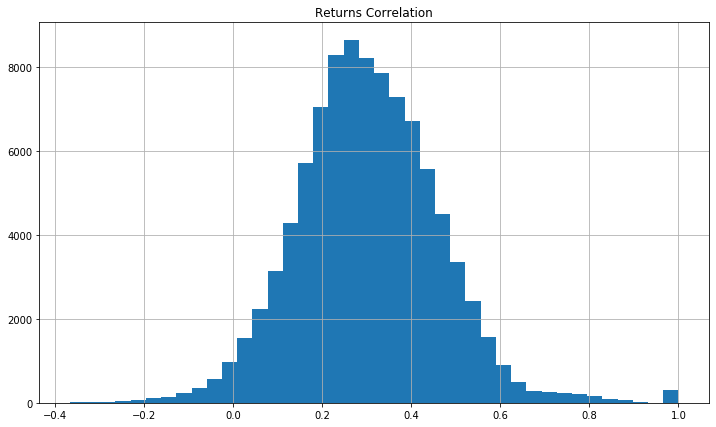

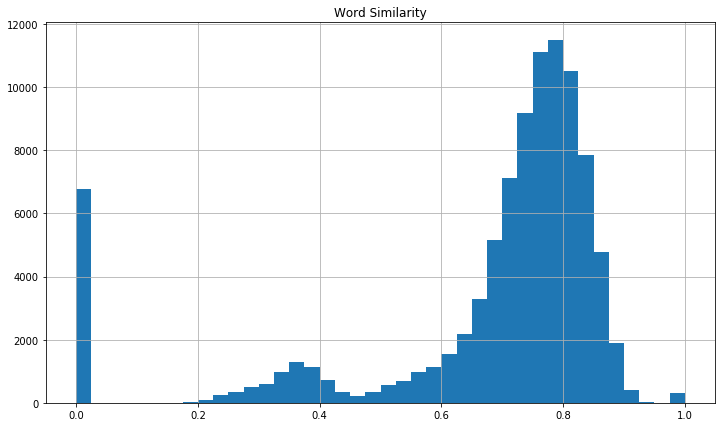

In [99]:
# inspect your data- make some histograms
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7))
all_data.returns_correlation.hist(bins=40)
plt.title('Returns Correlation')
plt.figure(figsize=(12,7))
all_data.word_similarity.hist(bins=40)
plt.title('Word Similarity')

### Cleaning our data
### It seems lots of things are identically 0 (no word overlap) or identically 1 (the MD&A section for one company perfectly overlaps itself). We will exclude those

In [100]:
all_data['word_similarity'][0]

1.0000000000000004

In [101]:
# your code here
all_data = all_data[(all_data['word_similarity'] < 1) & (all_data['word_similarity'] > 0)]

In [102]:
all_data

returns_correlation  word_similarity
ACN ADBE             0.555422         0.797598
    AMD              0.215997         0.775307
    AAP              0.231908         0.778956
    AES              0.351658         0.784401
    AMG              0.510561         0.709525
...                       ...              ...
ZTS XRX              0.382344         0.825251
    XLNX             0.344773         0.803660
    XYL              0.385495         0.813930
    YUM              0.344108         0.717907
    ZION             0.327581         0.771679

[86762 rows x 2 columns]

Text(0.5, 1.0, 'Word Similarity')

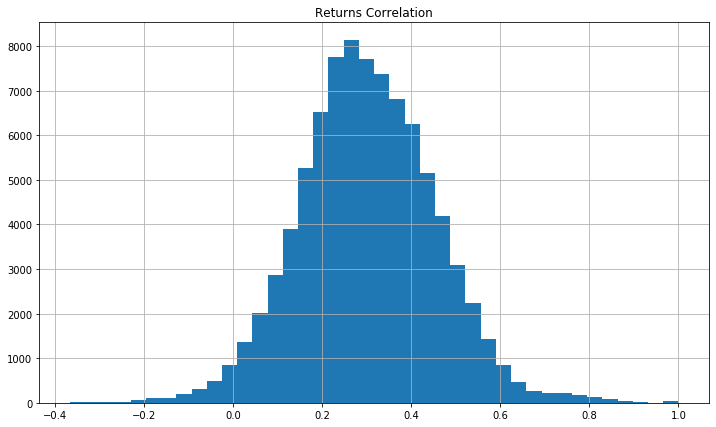

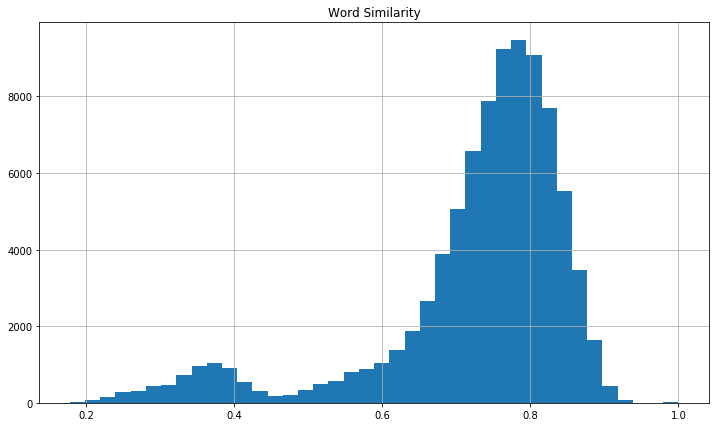

In [103]:
# examine histograms again
plt.figure(figsize=(12,7))
all_data.returns_correlation.hist(bins=40)
plt.title('Returns Correlation')
plt.figure(figsize=(12,7))
all_data.word_similarity.hist(bins=40)
plt.title('Word Similarity')

In [104]:
all_data.corr()

,returns_correlation,word_similarity
returns_correlation,1.000000,0.140083
word_similarity,0.140083,1.000000


### Lastly, there is a bit of a "hump" at low `word_similarity`

In [105]:
# add code here
all_data = all_data[(all_data['word_similarity'] > 0.6)]

In [106]:
all_data.corr()

,returns_correlation,word_similarity
returns_correlation,1.000000,0.224531
word_similarity,0.224531,1.000000


### The contemperaneous correlation is twice as large!

## Part 6: Now, repeat the exercise of predicting future returns correlation

In [107]:
data_df = np.array(all_data)# Add code here
# add code here
feature_cols = data_df[:,1:]
target_col = data_df[:,0]

In [108]:
reg = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(feature_cols,target_col,test_size=0.4, random_state=0)

reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.04745323471983143

In [109]:
reg.coef_

array([0.53144341])

In [110]:
#? pd.Series(reg.coef_, index=feature_cols)

### This is about 5 times better than before!
## $ \\ $ 
## Part 7: What will happen if we include last year's returns correlation as a feature

In [111]:
rets = prices.pct_change()
last_year_corr =  rets.loc['2015-01-01':'2016-01-01'].corr().stack().to_frame(name = 'last_year_returns_correlation')
data_df = last_year_corr.join(all_data)
data_df = data_df.dropna()
data_df.head()

last_year_returns_correlation  returns_correlation  word_similarity
ACN ADBE                       0.560746             0.555422         0.797598
    AMD                        0.251450             0.215997         0.775307
    AAP                        0.303237             0.231908         0.778956
    AES                        0.395799             0.351658         0.784401
    AMG                        0.622302             0.510561         0.709525

In [112]:
data_df = np.array(data_df)
feature_cols = data_df[:, [0,2]]
target_col = data_df[:, 1]

X_train, X_test, y_train, y_test = train_test_split(feature_cols, target_col, test_size=0.33, random_state=42)
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.3598212620553878

In [113]:
reg.coef_

array([0.64219806, 0.43440817])

In [114]:
#? pd.Series(reg.coef_, index=feature_cols)

## Indeed, we do much better, but the word features still help!